# Project Definition
Part two: ML for trading strategy, and program output

Now this part will look at three approaches to stock prediction machine learning in a Deep Neural Network (DNN) structure:
- DNN with Scikit-learn
- DNN with TensorFlow's DNNClassifier
- DNN with TensorFlow's DNNRegressor

The three approaches will be anaylzed with regards to returns, strategy, and graphs in regards to a best stock predictor.



In [1]:
# Import
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
#print(tf.__version__)

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
# import cleaned data from part 1
data_ML = pd.read_csv('data_ML')

In [4]:
data_ML2 = data_ML.copy()

In [5]:
data_ML.head().round(2)

,Date,SPY,SMA1,SMA2,Position,Returns,Strategy,direction
0,2016-01-04,186.84,191.24,189.24,1,-0.01,-0.01,-1
1,2016-01-05,187.15,191.05,189.25,1,0.00,0.00,1
2,2016-01-06,184.79,190.82,189.26,1,-0.01,-0.01,-1
3,2016-01-07,180.36,190.49,189.25,1,-0.02,-0.02,-1
4,2016-01-08,178.38,190.12,189.21,1,-0.01,-0.01,-1


# Methodology

1. We will be shifting the data into mulitple columns and bins
2. Delete NaN empty values


In [6]:
# the stock of S&P 500 is being used in this example, 
# as noted earlier, results are more apparent and dynamic with stock
symbol = 'SPY'

Now we put the data into shifted columns from the stock price known as lags.  Here is the code below:

In [7]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data_ML[col] = data_ML[symbol].shift(lag)  
    cols.append(col)  

In [8]:
data_ML.head(7)

,Date,SPY,SMA1,SMA2,Position,Returns,Strategy,direction,lag_1,lag_2,lag_3,lag_4,lag_5
0,2016-01-04,186.836166,191.235993,189.238119,1,-0.014078,-0.014078,-1,NaN,NaN,NaN,NaN,NaN
1,2016-01-05,187.152161,191.050289,189.251833,1,0.001690,0.001690,1,186.836166,NaN,NaN,NaN,NaN
2,2016-01-06,184.791367,190.822455,189.263046,1,-0.012695,-0.012695,-1,187.152161,186.836166,NaN,NaN,NaN
3,2016-01-07,180.357925,190.493684,189.247667,1,-0.024284,-0.024284,-1,184.791367,187.152161,186.836166,NaN,NaN
4,2016-01-08,178.378235,190.120196,189.211459,1,-0.011037,-0.011037,-1,180.357925,184.791367,187.152161,186.836166,NaN
5,2016-01-11,178.554810,189.794029,189.181915,1,0.000989,0.000989,1,178.378235,180.357925,184.791367,187.152161,186.836166
6,2016-01-12,179.995468,189.491603,189.163869,1,0.008036,0.008036,1,178.554810,178.378235,180.357925,184.791367,187.152161


In [9]:
# we need to drop the NaN else the data learning will get messy and may not work
data_ML.dropna(inplace=True)

In [10]:
# I have to add several lags otherwise the returns and strategy will be the same or near the same values

lags = 5

def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data_ML[col] = data_ML['Returns'].shift(lag)
        cols.append(col)


In [11]:
create_lags(data_ML)

Also a reminder that Returns are the annualized rolling standard deviation of the log returns (or simply volatility).
Volatility is the degree of variation of a trading price over time.

In [12]:
# The mean log return
mu = data_ML['Returns'].mean()  
# The standard deviation
v = data_ML['Returns'].std()  

In [13]:
# this digitizes the features data.
bins = [mu - v, mu, mu + v]  
bins  

[-0.0075634834904770671, 0.00056700374447253685, 0.008697490979422141]

In [14]:
# normalize the data similar to sklearn.preprocessing.StandardScaler
# find section off each bin, and categorize it as being positive or negative, 
# with 0 being negative and 1 being postive
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data_ML[col_bin] = np.digitize(data_ML[col], bins=bins) #np.digitize returns the integer to which the digits belongs
        cols_bin.append(col_bin)

In [15]:
create_bins(data_ML)

In [16]:
data_ML.head().round(3)

,Date,SPY,SMA1,SMA2,Position,Returns,Strategy,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
5,2016-01-11,178.555,189.794,189.182,1,0.001,0.001,1,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1
6,2016-01-12,179.995,189.492,189.164,1,0.008,0.008,1,0.001,NaN,NaN,NaN,NaN,1,1,1,1,1
7,2016-01-13,175.506,189.100,189.130,-1,-0.025,-0.025,-1,0.008,0.001,NaN,NaN,NaN,1,1,1,1,1
8,2016-01-14,178.387,188.841,189.112,-1,0.016,-0.016,1,-0.025,0.008,0.001,NaN,NaN,0,1,1,1,1
9,2016-01-15,174.558,188.542,189.086,-1,-0.022,0.022,-1,0.016,-0.025,0.008,0.001,NaN,1,0,1,1,1


## Deep Neural Network

**What is a Deep Neural Network?** A Deep Neural Network (DNN) ia an artificial neural network with multiple layers between the input and output layers. This synthetic process emulates the thinking process of the human brain.  DNN contains hidden layers which help facilitate more complex relationships between layers and parts.

### DNN with scikit-learn

**Why Scikit-learn and DNN?** Scikit-learn is utlizied by many industries to build machine learning models.  It is easy to use, easy for manipulating constraints, and can be flexible for use. Scikit-learn has a neural networks algorithms that have hidden layers which is central to DNN.

We will be using the **MLPClassifier**.  MLPClassifier uses a Multi-layer Perceptron (MLP) algorithm and trains using Backpropagation.  This function can used for either classification or regression.  A Multi-layer Perceptron (MLP) can learn models in real-time which is important in relation to real-time changing stock data.

Evaluation first without the test train split, more so for pre-testing:

In [17]:
# without test_train_split
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [18]:
%time model.fit(data_ML[cols_bin], data_ML['direction'])

CPU times: user 17.1 s, sys: 9.41 s, total: 26.5 s
Wall time: 6.78 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[250, 250], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [19]:
data_ML['pos_dnn_sk'] = model.predict(data_ML[cols_bin])

In [20]:
data_ML['strat_dnn_sk'] = data_ML['pos_dnn_sk'] * data_ML['Returns']

In [21]:
data_ML[['Returns', 'strat_dnn_sk']].sum().apply(np.exp)

Returns         1.746065
strat_dnn_sk    1.808832
dtype: float64

A reminder: 
- Returns are the annualized rolling standard deviation of the log returns (or simply volatility)
- Strategy or 'strat_dnn_sk' is the log returns of the trading strategy derived the prediction values and the benchmark log returns.

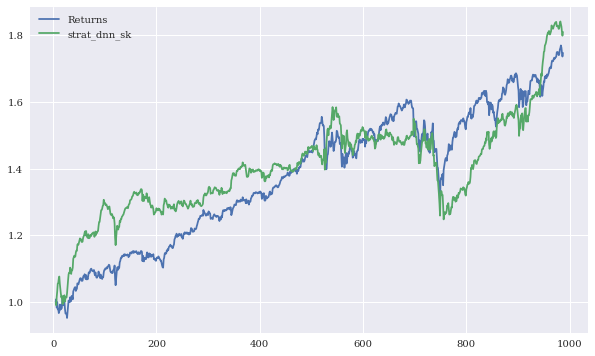

In [22]:
data_ML[['Returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

Clearly as the graph shows, this model can preform well. But this model knows the dataset too well and is also considered overfitting.  In real life the machine will not have foreknowledge of the dataset but will have to learn to make foreknowledge.

Now a adding a test_train_split is necessary as to avoid overfitting of the DNN model.  The test_size and random state will be standardized at the same values to allow for quality comparisions between packages. (just like a scientific test)

In [23]:
# the split is randomized — this is emulating reality, where an algorithm during trading is faced with 
# new data on a continuous basis.
train, test = train_test_split(data_ML, test_size=0.33, random_state=100)

In [24]:
train = train.copy().sort_index()  

In [25]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
9,1,0,1,1,1
10,0,1,0,1,1


In [26]:
test = test.copy().sort_index()  

In [27]:
# lets try 3 hidden layers with 500 nodes instead of 2 hidden layers with 250 nodes
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [28]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 1min 22s, sys: 39.1 s, total: 2min 1s
Wall time: 30.8 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [29]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [30]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['Returns']

# Results

In [31]:
test[['Returns', 'strat_dnn_sk']].sum().apply(np.exp)

Returns         1.265743
strat_dnn_sk    1.007196
dtype: float64

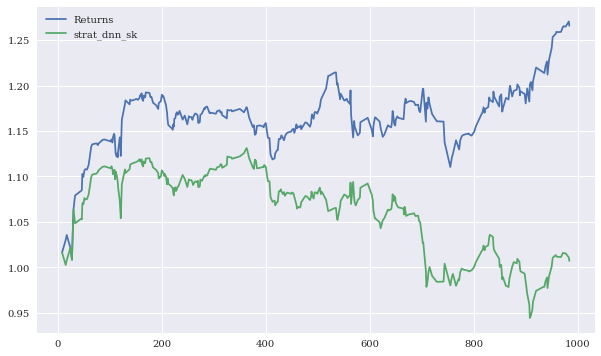

In [32]:
test[['Returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

As the results of a more realistic approach show, the strategy did not preform as well as the returns, and started to preform worse near the end.  However, more investigation can be looked at in setting up the MLClassifier parameters to change for a better result.  There is evidence that this approach can work with the right parameters as shown in the book "Python for Finance".  The hidden_layer_sizes for the first one without test_train_split is [250, 250], while the second one is [500, 500, 500].  I wounder if this could make a difference

In [33]:
# the split is randomized — this is emulating reality, where an algorithm during trading is faced with 
# new data on a continuous basis.
train, test = train_test_split(data_ML, test_size=0.33, random_state=100)

In [34]:
train = train.copy().sort_index()  

In [35]:
test = test.copy().sort_index()  

In [36]:
# lets try 3 hidden layers with 250 nodes instead of 2 hidden layers with 500 nodes
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [250], random_state=1)  

In [37]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 14.9 s, sys: 7.6 s, total: 22.5 s
Wall time: 5.75 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[250, 250, 250], learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [38]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [39]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['Returns']

# Results

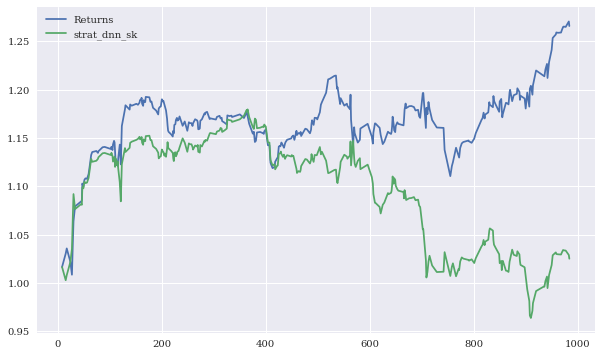

In [40]:
test[['Returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

Surprisingly, that made a difference.  Less hidden nodes made the strategy near equal to the returns.  This is a better approach however it did not beat the returns.

### DNN with TensorFlow

In [41]:
test[['Returns', 'strat_dnn_sk']].sum().apply(np.exp)

Returns         1.265743
strat_dnn_sk    1.025006
dtype: float64

**Why TensorFlow and DNN?**  Since being released in 2015, TensoFlow by Google has show good results in academic papers, blog posts, and videos.  The program has made good results on Machine learning. 

As one article put it, "TensorFlow's Github repository has nearly twice the number of stars of both the next most-starred machine learning project, Scikit-learn, and closest deep learning project, Berkeley Vision and Learning Center's Caffe"(Matthew Mayo).

TensorFlow works with making placeholders and variables to define an abstract represenation of the model.  Then these placeholders get replaced with actual real data and computations are made.

In [42]:
import tensorflow as tf

# tell TensorFlow to tell all messages that have the label error
tf.logging.set_verbosity(tf.logging.ERROR)


In [43]:
feature_columns = [tf.contrib.layers.real_valued_column('lags', dimension=lags)]

We will first be using a **DNNClassifier**.  A DNNClassifier predicts which category an input sample belongs to.

In [44]:
# initiate model
# using 3 hidden layers with 500 nodes
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500],
                                       n_classes=len(bins) + 1,
                                       feature_columns=feature_columns)

TensorFlow is **strict** on the type of data that is imported into the model.  For the data, it has to be a tensor composing of vectors and matrices.  TensorFlow has its own rules about inputs and one must conform to these, else you will get errors.  Common errors are ValueError and IndexError.

In [45]:
# create an organized input for tensorflow

# - scalling is typically done since most common activation functions are built on that scale
# Some people typicall use sklearn.preprocessing.StandardScaler however, 
# this is not necessary since our data is aready scaled within a limit.
# - scale the directional data from 0 to 1


def input_fn():
    fc = {'lags': tf.constant(data_ML[cols_bin].values)}
    la = tf.constant(data_ML['direction'].apply(lambda x: 0 if x < 0 else 1).values, # tf.constant is a constant tensor with value and shape
                     shape=[data_ML['direction'].size, 1])
    return fc, la

Evaluation without test_train_split or any split:

In [46]:
# fit and time model
%time model.fit(input_fn=input_fn, steps=500)  

CPU times: user 3.49 s, sys: 796 ms, total: 4.28 s
Wall time: 5.45 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7f460be3eba8>, 'hidden_units': [500, 500, 500], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=5, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7f461bdb6a60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [47]:
model.evaluate(input_fn=input_fn, steps=1)  

{'loss': 0.67556256, 'accuracy': 0.56765008, 'global_step': 500}

In [48]:
pred = np.array(list(model.predict(input_fn=input_fn)))  
pred[:10]  

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
# put the data back on the -1 to 1 scale
data_ML['pos_dnn_tf'] = np.where(pred > 0, 1, -1)  

In [50]:
data_ML['strat_dnn_tf'] = data_ML['pos_dnn_tf'] * data_ML['Returns']

# Results

In [51]:
data_ML[['Returns', 'strat_dnn_tf']].sum().apply(np.exp)

Returns         1.746065
strat_dnn_tf    1.775381
dtype: float64

Note the predictions without the test_train_split are nearly equal with the strategy performing slightly better in one reset while worse in another.  However, as mentioned before, this is not realistic, since again we do not have foreknowledge of the stock market.

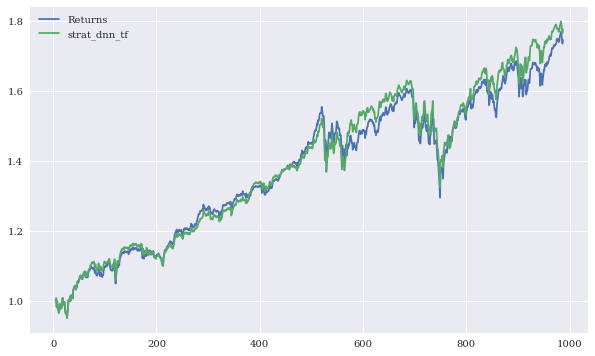

In [52]:
data_ML[['Returns', 'strat_dnn_tf']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [53]:
model = tf.contrib.learn.DNNClassifier(hidden_units=3 * [500],
                                       n_classes=len(bins) + 1,
                                       feature_columns=feature_columns)

Now a adding a test-train split is necessary as to avoid overfitting of the DNN model.  Using the same test train split from the past sklearn DNN module

In [54]:
data_ML = train

In [55]:
%time model.fit(input_fn=input_fn, steps=2500)

CPU times: user 10.7 s, sys: 1.85 s, total: 12.5 s
Wall time: 10.5 s


DNNClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x7f4616bdaef0>, 'hidden_units': [500, 500, 500], 'feature_columns': (_RealValuedColumn(column_name='lags', dimension=5, default_value=None, dtype=tf.float32, normalizer=None),), 'optimizer': None, 'activation_fn': <function relu at 0x7f461bdb6a60>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [56]:
data_ML = test

In [57]:
model.evaluate(input_fn=input_fn, steps=1)

{'loss': 0.69696522, 'accuracy': 0.51692307, 'global_step': 2500}

In [58]:
predictions = np.array(list(model.predict(input_fn=input_fn)))
predictions[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

In [59]:
test['pos_dnn_tf'] = np.where(predictions > 0, 1, -1)

In [60]:
test['strat_dnn_tf'] = test['pos_dnn_tf'] * test['Returns']

# Results

In [61]:
test[['Returns', 'strat_dnn_sk', 'strat_dnn_tf']].sum().apply(np.exp)

Returns         1.265743
strat_dnn_sk    1.025006
strat_dnn_tf    1.037167
dtype: float64

The strategy of DNN tensorflow preformed a bit better than that of scikit-learn.  However, it did not beat the returns.

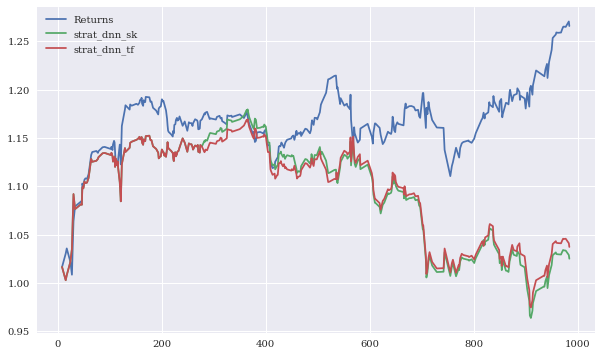

In [62]:
test[['Returns', 'strat_dnn_sk', 'strat_dnn_tf']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

interestingly, all three lines are all equal at about 150, then only two lines are equal at 200.

### Approach 2:  DNNRegressor, with different boundaries

We will be now using a **DNNRegressor**. A DNNRegressor is similar to a DNNClassifier, however it predicts a numeric value in a continuous range.

In [63]:
train, test = train_test_split(data_ML, test_size=0.33, random_state=100)

In [64]:
test = test.copy().sort_index()  

In [65]:
# optimizer, in this case the Adam Optimizer, 
# this updates network weights iteratives over time based in training data

opti = tf.train.AdamOptimizer(learning_rate = 0.01)

In [66]:
feature_columns = [tf.contrib.layers.real_valued_column('lags', dimension=lags)]

In [67]:
# initiate model

model = tf.estimator.DNNRegressor(hidden_units=[9,9,3], 
                                      feature_columns=feature_columns, 
                                      optimizer=opti, 
                                      dropout=0.5)

In [68]:
# create an organized input for tensorflow

# - scalling is typically done since most common activation functions are built on that scale
# Some people typicall use sklearn.preprocessing.StandardScaler however, 
# this is not necessary since our data is aready scaled within a limit.
# - scale the directional data from 0 to 1



def input_fn():
    fc = {'lags': tf.constant(data_ML[cols_bin].values)}
    la = tf.constant(data_ML['direction'].apply(lambda x: 0 if x < 0 else 1).values, # tf.constant is a constant tensor with value and shape
                     shape=[data_ML['direction'].size, 1])
    return fc, la

In [69]:
# fit and time model
%time model.train(input_fn=input_fn, steps=500)  

CPU times: user 3.65 s, sys: 499 ms, total: 4.15 s
Wall time: 2.69 s


Evaluation without the formal test_train_split, but still split

In [70]:
model.evaluate(input_fn=input_fn, steps=1)  

{'average_loss': 0.24643038, 'loss': 80.089874, 'global_step': 500}

This loss is very good and the model may not show good results.  The loss from the DNNClassifer model was 0.56765008 for all the data.

In [71]:
import itertools
import re

# model predict will go on forever, so we need to user an iteration limit
y = model.predict(input_fn=input_fn)

# .predict() returns an iterator; convert to a list and print predictions
predictions = list(itertools.islice(y, len(data_ML2)))

#print("Predictions: {}".format(str(predictions)))
predictions = pd.DataFrame(predictions).astype(int)


In [72]:
# put the data back on the -1 to 1 scale

data_ML2['pos_dnn_tf'] = np.where(predictions > 0, 1, -1)


In [73]:
data_ML['strat_dnn_tf_2'] = data_ML['pos_dnn_tf'] * data_ML['Returns']

# Results

In [74]:
data_ML[['Returns', 'strat_dnn_tf_2']].sum().apply(np.exp)

Returns           1.265743
strat_dnn_tf_2    1.037167
dtype: float64

In [75]:
data_ML[['Returns','strat_dnn_tf','strat_dnn_tf_2']].sum().apply(np.exp)


Returns           1.265743
strat_dnn_tf      1.037167
strat_dnn_tf_2    1.037167
dtype: float64

The DNNRegressor preformed the same as DNNClassifier without any test_train_split

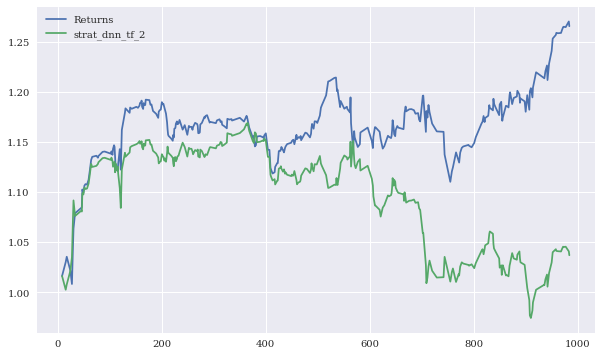

In [76]:
data_ML[['Returns', 'strat_dnn_tf_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

###  Three comparisons


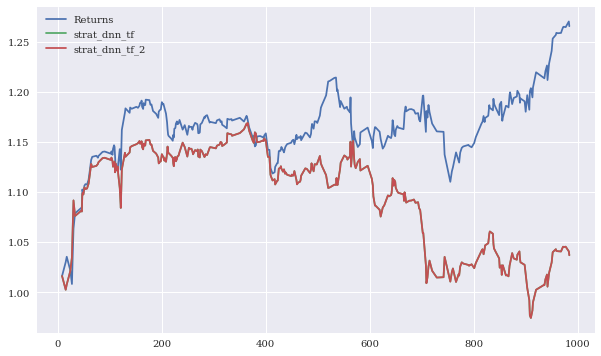

In [77]:
data_ML[['Returns', 'strat_dnn_tf', 'strat_dnn_tf_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

In [78]:
# initiate model

model = tf.estimator.DNNRegressor(hidden_units=[9,9,3], 
                                      feature_columns=feature_columns, 
                                      optimizer=opti, 
                                      dropout=0.5)

Now a adding a test-train split is necessary as to avoid overfitting of the DNN model.  Using the same test train split from the past DNN module

In [79]:
data_ML = train

In [80]:
%time model.train(input_fn=input_fn, steps=2500)

CPU times: user 13.2 s, sys: 2.26 s, total: 15.4 s
Wall time: 8 s


In [81]:
data_ML = test

In [82]:
model.evaluate(input_fn=input_fn, steps=1)

{'average_loss': 0.24692443, 'loss': 26.667839, 'global_step': 2500}

This loss is very big and may not show any good results.  The loss from the DNNClassifier for the test data was 0.52615386.  However, the test DNNRegressor is significantly different with a value of 26.667839 compared to the whole data DNNRegressor with a value of 80.085297.

In [83]:
# model predict will go on forever, so we need to user an iteration limit
y = model.predict(input_fn=input_fn)

# .predict() returns an iterator; convert to a list and print predictions
predictions_test = list(itertools.islice(y, len(test)))

#print("Predictions: {}".format(str(predictions)))
predictions_test = pd.DataFrame(predictions_test).astype(int)


In [84]:
test['pos_dnn_tf'] = np.where(predictions_test > 0, 1, -1)

# Results

In [85]:
test['strat_dnn_tf_2'] = test['pos_dnn_tf'] * test['Returns']

In [86]:
test[['Returns', 'strat_dnn_tf_2']].sum().apply(np.exp)

Returns           1.186454
strat_dnn_tf_2    0.842848
dtype: float64

The test strategy of this DNNRegressor with a value of 0.842848 is less than test strategy of the DNNClassifier with a value of 1.037005.  Comparably, the test strategy of the scikit-learn classifier is between these values with a value of 1.007196.

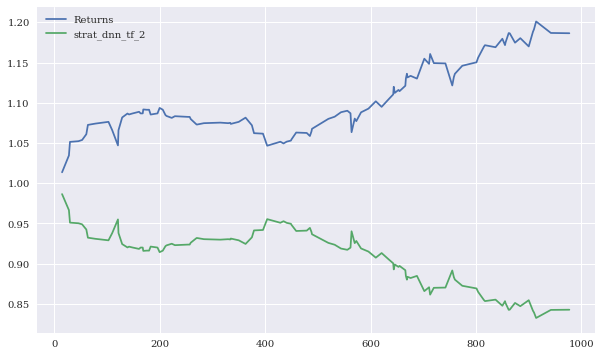

In [87]:
test[['Returns', 'strat_dnn_tf_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

As the graph shows, the relationship between the strategy to the returns is a inversed mirrored relationship.

### Changing the nodes

I did notice, my hidden units are significantly less than the other test with node values of [9,9,3] respectfully for each layer.  This is the amount that was recommended on the tensorflow website example. I will now preform a quick test and change these nodes:

In [88]:
train, test = train_test_split(data_ML, test_size=0.33, random_state=100)

In [89]:
test = test.copy().sort_index()  

In [90]:
# change the nodes and initiate the model

model = tf.estimator.DNNRegressor(hidden_units=3 * [500], 
                                      feature_columns=feature_columns, 
                                      optimizer=opti, 
                                      dropout=0.5)

Now a adding a test-train split is necessary as to avoid overfitting of the DNN model.  Using the same test train split from the past DNN module

In [91]:
data_ML = train

In [92]:
%time model.train(input_fn=input_fn, steps=2500)

CPU times: user 14.9 s, sys: 2.62 s, total: 17.5 s
Wall time: 9.93 s


In [93]:
data_ML = test

In [94]:
model.evaluate(input_fn=input_fn, steps=1)

{'average_loss': 0.24878486, 'loss': 8.956255, 'global_step': 2500}

This loss is very better than the past two models.  I think this might work.  As a reminder, the loss from the DNNClassifier for the test data was 0.52615386, and the loss from the DNNRegressor for the test data was 26.667839. 

In [95]:
# model predict will go on forever, so we need to user an iteration limit
y = model.predict(input_fn=input_fn)

# .predict() returns an iterator; convert to a list and print predictions
predictions_test = list(itertools.islice(y, len(test)))

#print("Predictions: {}".format(str(predictions)))
predictions_test = pd.DataFrame(predictions_test).astype(int)


In [96]:
test['pos_dnn_tf'] = np.where(predictions_test > 0, 1, -1)

# Results

In [97]:
test['strat_dnn_tf_2'] = test['pos_dnn_tf'] * test['Returns']

In [98]:
test[['Returns', 'strat_dnn_tf_2']].sum().apply(np.exp)

Returns           1.042691
strat_dnn_tf_2    0.959057
dtype: float64

The test strategy of this DNNRegressor is the same value from the past test strategy of the DNNRegressor.   As a reminder, the test strategy of this DNNRegressor with a value of 0.842848 is less than test strategy of the DNNClassifier with a value of 1.037005.  Comparably, the test strategy of the scikit-learn classifier is between these values with a value of 1.007196.

No need to show the graph, since it is exactly the same.

# Conclusion

Out of the three methods, DNNRegressor performed the worst while the DNNClassifier performed the best.  For the two Tensorflow methods, the DNNRegressor performed worse than the DNNClassifier despite the changes made in node amounts.

It is very interesting that within the three methods studied, all of the whole dataset model's graph return lines are the same while all the test model's graph return lines are all the same.

As a friendly reminder, **I would advise one not to trade based off this information and models in this notebook** as it is too risky.  More examination and studing is needed before trading with one of these approaches. I would choose the DNNClassifier, as it showed the best results, to investigate further and build off of.

Please do keep in mind that there are other methods, I only tested a few of them based off the limits and review time of this Udacity based project.